In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"   # Force CUDA to be synchronous

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

from tqdm.notebook import tqdm
import re
from datasets import Dataset
from wordcloud import WordCloud
from scipy.stats import t

## 1. Data Loading and Initial Exploration

In this section, we load the training dataset and perform an initial exploratory analysis:  
- Check the shape and structure of the data  
- View several sample rows  
- Visualize class and year distributions  
- Calculate the average and median length of texts


In [2]:
DATASET = pd.read_csv("train.csv")

In [3]:
df = DATASET

print("Number of samples:", len(df))
print("Columns:", df.columns.tolist())
print("Number of unique classes:", df['class'].nunique())
print("Years in the dataset:", sorted(df['year'].unique()))

display(df.sample(10))


Number of samples: 216974
Columns: ['id', 'text', 'class', 'year']
Number of unique classes: 21
Years in the dataset: [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]


,id,text,class,year
165632,165632,Substitució de l'alcalde durant la seva absència.,9,2018
33412,33412,Aprovació definitiva del pressupost del 2013.,12,2013
125336,125336,Aprovació definitiva del pressupost únic 2017 ...,12,2017
128889,128889,Aprovació de les bases reguladores del II Prem...,15,2017
17415,17415,Exposició al públic del compte general de l'ex...,12,2013
98645,98645,Baixes del Padró Municipal d'Habitants.,10,2015
162726,162726,Aprovació definitiva del conveni urbanístic en...,17,2018
65692,65692,Notificación de acuerdo de inicio de expedient...,14,2014
197564,197564,Convocatòria de subvencions de l'IBI 2019 per ...,15,2020
59550,59550,Notificació a un particular.,19,2014


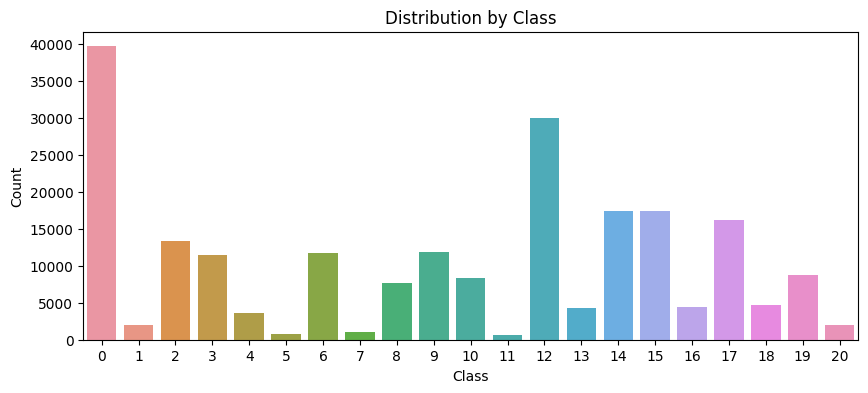

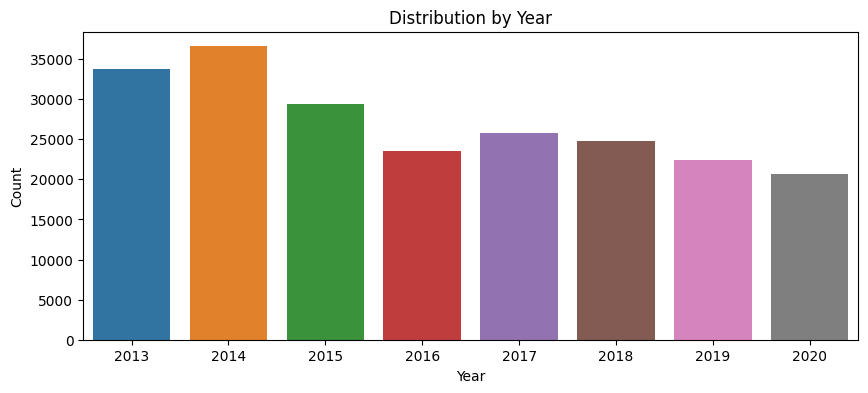

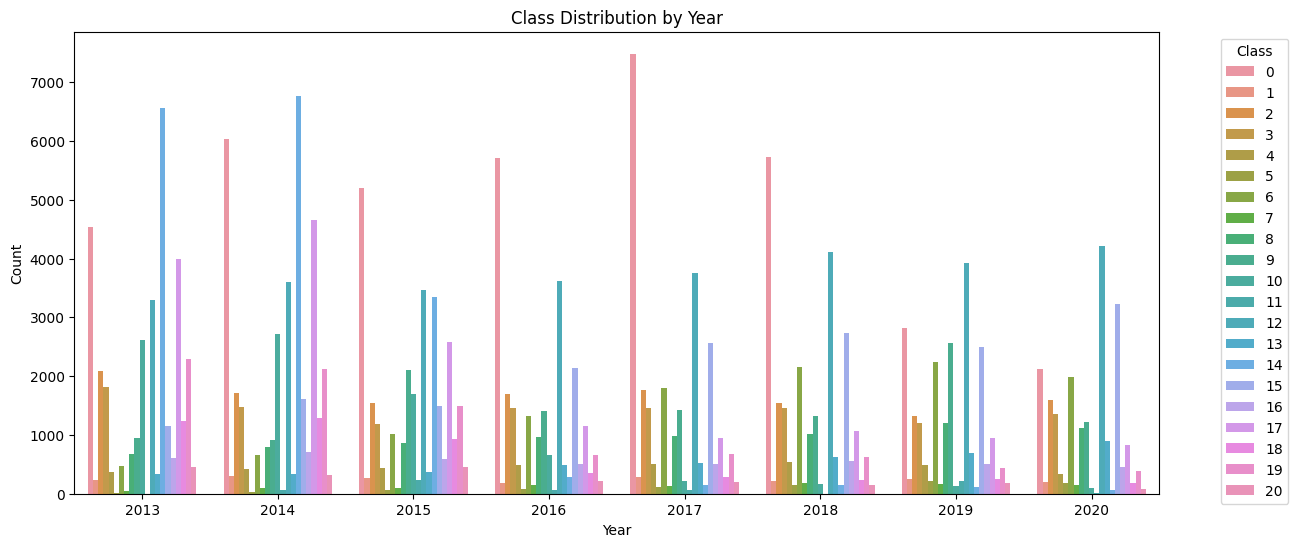

In [4]:
# Distribution of samples across classes to identify any class imbalance, which can affect training and evaluation.
plt.figure(figsize=(10,4))
sns.countplot(x='class', data=df)
plt.title('Distribution by Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Distribution of samples by year to check for temporal patterns or data skews that may influence model generalization.
plt.figure(figsize=(10,4))
sns.countplot(x='year', data=df)
plt.title('Distribution by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

# Distribution of classes within each year
plt.figure(figsize=(14,6))
sns.countplot(x='year', hue='class', data=df)
plt.title('Class Distribution by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [5]:
# Compute the length of each text in characters; this helps in understanding text size variability and guides preprocessing (e.g., max sequence length for BERT).
df['text_len_chars'] = df['text'].str.len()

# Compute the length of each text in words to get additional statistics about text complexity and to compare with character-based length.
df['text_len_words'] = df['text'].str.split().apply(len)

# Output average and median values to summarize dataset and support decisions on padding/truncation for modeling.
print("Average text length (characters):", df['text_len_chars'].mean())
print("Median text length (characters):", df['text_len_chars'].median())
print("Average text length (words):", df['text_len_words'].mean())
print("Median text length (words):", df['text_len_words'].median())


Average text length (characters): 99.16521334353425
Median text length (characters): 94.0
Average text length (words): 14.576990791523409
Median text length (words): 14.0


### Summary of Data Exploration

- The dataset shows a strong class imbalance:
  - Classes 0 and 12 are much more frequent than others.
  - Several classes (such as 5, 7, 13, 15, and 20) have very few samples, which may lead to poor generalization for these classes.
- The average text is short (~99 characters or ~14 words).
- Year distribution is skewed toward earlier years (2013–2014).

**To mitigate the impact of class imbalance, we will:**
- Use stratified train/validation split to preserve class proportions during training and evaluation.
- Monitor not only overall accuracy but also macro-F1 and the confusion matrix to assess performance across all classes, including minority ones.
- Consider implementing class weights in the loss function if we observe poor recognition of rare classes during validation.


## 2. Text Cleaning and Basic Preprocessing

In this section:
- Convert all texts to lowercase.
- Remove special characters, keeping only letters, numbers, and spaces.
- Stopwords (including Catalan function words) are intentionally preserved, as transformer-based models benefit from full sentence structure.
- Analyze how text cleaning affects text length and update statistics.

In [6]:
def clean_text(text):
    # Convert all characters to lowercase for normalization and to reduce vocabulary size for the model.
    text = text.lower()
    # Remove all characters except letters (including accented), digits, and spaces to standardize input for tokenization.
    text = re.sub(r'[^a-zà-ÿ0-9\s]', '', text)
    # Replace multiple consecutive spaces with a single space and trim edges to avoid artificial token inflation.
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [7]:
df['clean_text'] = df['text'].apply(clean_text)

### Analyze the Effect of Text Cleaning

Compare average and median lengths of original and cleaned texts to understand the impact of preprocessing.


In [8]:
# Recalculate character and word lengths after cleaning to check if cleaning significantly shortens the text or changes its structure.
df['clean_len_chars'] = df['clean_text'].str.len()
df['clean_len_words'] = df['clean_text'].str.split().apply(len)

# Print updated statistics to support decisions about input sequence length for the model.
print("Average cleaned text length (characters):", df['clean_len_chars'].mean())
print("Median cleaned text length (characters):", df['clean_len_chars'].median())
print("Average cleaned text length (words):", df['clean_len_words'].mean())
print("Median cleaned text length (words):", df['clean_len_words'].median())

Average cleaned text length (characters): 96.20189515794519
Median cleaned text length (characters): 92.0
Average cleaned text length (words): 14.565832772590264
Median cleaned text length (words): 14.0


### Conclusion

No significant changes in text length after cleaning.


### Summary of Model Improvement Process After First Iteration

After the first iteration of model training and confusion matrix analysis, we detected a systematic bias: certain class pairs were repeatedly confused by the models. These errors were most pronounced in classes with broad or overlapping language, as well as in minority categories.

To mitigate this, we decided to augment each input by appending automatically extracted TF-IDF keywords to the cleaned text. This strategy is intended to explicitly signal the most informative terms to the model, helping it better separate semantically similar classes and giving more prominence to underrepresented ones, all without altering the underlying model architecture or requiring manual intervention.


In [9]:
# fit TF-IDF on existing cleaned texts
vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = vectorizer.fit_transform(df['clean_text'])
feature_names = np.array(vectorizer.get_feature_names_out())

# extract top-n keywords per document
def extract_top_n(row, features, n=3):
    indices = np.argsort(row.toarray().ravel())[-n:]
    return features[indices]

df['keywords'] = [
    extract_top_n(tfidf_matrix[i], feature_names, n=5).tolist()
    for i in range(len(df))
]

# append keywords to clean_text for model input
df['model_input'] = df['clean_text'] + ' [KEYWORDS] ' + df['keywords'].str.join(' ')


In [10]:
df.sample(10)

,id,text,class,year,text_len_chars,text_len_words,clean_text,clean_len_chars,clean_len_words,keywords,model_input
169230,169230,Formalització dels serveis de neteja i prepara...,0,2018,155,26,formalització dels serveis de neteja i prepara...,151,26,"[piscines, temporada, llorenç, serveis, prepar...",formalització dels serveis de neteja i prepara...
179207,179207,"Formalització del subministrament, muntatge i ...",0,2019,176,27,formalització del subministrament muntatge i p...,172,27,"[posada, marxa, quadres, decantadors, 12]",formalització del subministrament muntatge i p...
24443,24443,Notificació d'expedients sancionadors.,14,2013,38,3,notificació dexpedients sancionadors,36,3,"[desglossat, ús, notificació, sancionadors, de...",notificació dexpedients sancionadors [KEYWORDS...
5846,5846,Exposició pública d'un expedient per a l'autor...,17,2013,128,17,exposició pública dun expedient per a lautorit...,122,17,"[exposició, installació, lautorització, magatz...",exposició pública dun expedient per a lautorit...
125292,125292,Aprovació definitiva de les bases reguladores ...,15,2017,178,25,aprovació definitiva de les bases reguladores ...,173,25,"[20162017, temporada, pràctica, adreçades, pre...",aprovació definitiva de les bases reguladores ...
168544,168544,Aprovació inicial de la instrucció reguladora ...,17,2018,110,16,aprovació inicial de la instrucció reguladora ...,109,16,"[municipi, sense, registre, solars, instrucció]",aprovació inicial de la instrucció reguladora ...
179871,179871,Aprovació de la delegació a favor de l'Àrea Me...,17,2019,136,21,aprovació de la delegació a favor de làrea met...,134,21,"[làrea, funcions, favor, metropolitana, refere...",aprovació de la delegació a favor de làrea met...
139611,139611,Licitació de les obres d'arranjament del camí ...,0,2017,106,18,licitació de les obres darranjament del camí r...,103,18,"[llorenç, termes, ral, gallifa, savall]",licitació de les obres darranjament del camí r...
106161,106161,Aprovació de les bases i convocatòria del proc...,6,2016,126,19,aprovació de les bases i convocatòria del proc...,121,19,"[social, parcial, treballadora, temps, relleu]",aprovació de les bases i convocatòria del proc...
137886,137886,Aprovació inicial de l'Ordenança fiscal núm. 1...,2,2017,130,21,aprovació inicial de lordenança fiscal núm 18b...,126,21,"[la, prestació, de, celebració, casaments]",aprovació inicial de lordenança fiscal núm 18b...


In [11]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.colheader_justify', 'left') 

print(df['model_input'].sample(10))
pd.set_option('display.max_colwidth', 80)
pd.set_option('display.colheader_justify', 'right') 

201819                         aprovació de les bases de subvenciones en règim de concurrència competitiva a entitats municipals per a lany 2020 versió en català [KEYWORDS] en competitiva versió subvenciones català
205657                                                         aprovació de la convocatòria i de les bases del procés selectiu per crear una borsa deducadora social [KEYWORDS] borsa selectiu social deducadora crear
140068                                                        adjudicació del contracte dobra material del projecte de lestació de tractament daigua potable etap [KEYWORDS] material potable tractament lestació etap
138485    resolució del tancament dadmissió de sollicituds dinformes didoneïtat del programa de millora de laccessibilitat de lany 2017 a làmbit de lamb [KEYWORDS] tancament laccessibilitat lamb dadmissió dinformes
170411                                                                           bases i convocatòria per a la creació duna borsa de treball

In [12]:
# Recalculate character and word lengths after cleaning to check if cleaning significantly shortens the text or changes its structure.
df['model_input_len_chars'] = df['model_input'].str.len()
df['model_input_len_words'] = df['model_input'].str.split().apply(len)

# Print updated statistics to support decisions about input sequence length for the model.
print("Average cleaned text length (characters):", df['model_input_len_chars'].mean())
print("Median cleaned text length (characters):", df['model_input_len_chars'].median())
print("Average cleaned text length (words):", df['model_input_len_words'].mean())
print("Median cleaned text length (words):", df['model_input_len_words'].median())

Average cleaned text length (characters): 149.62145694875883
Median cleaned text length (characters): 145.0
Average cleaned text length (words): 20.565832772590266
Median cleaned text length (words): 20.0


In [13]:
+

SyntaxError: invalid syntax (15193383.py, line 1)

## 3. Train/Validation Split

We perform a stratified split to preserve class proportions in both the training and validation sets, which helps mitigate class imbalance during model training and evaluation.


In [ ]:
train_df, val_df = train_test_split(
    df, 
    test_size=0.2, 
    stratify=df['class'], 
    random_state=2025
)

# Rename target column to 'labels' for Trainer compatibility
train_df = train_df.rename(columns={"class": "labels"})
val_df   = val_df.rename(columns={"class": "labels"})

print("Training samples:", len(train_df))
print("Validation samples:", len(val_df))

Training samples: 173579
Validation samples: 43395


## 4. Tokenization and Preparation for Training

- Select a BERT model en catalan
- Load the tokenizer using AutoTokenizer.
- Tokenize the texts and prepare PyTorch datasets for the Trainer.


In [ ]:
model_checkpoint = "PlanTL-GOB-ES/roberta-base-ca"

# Load the pretrained BERT tokenizer to convert texts into input IDs and attention masks.
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

max_length = 128  # Cover occasional longer texts and better leverage available GPU memory

def tokenize_batch(batch):
    # Tokenize texts, truncating or padding to a fixed max_length for batch processing.
    return tokenizer(
        batch["model_input"], 
        padding="max_length", 
        truncation=True, 
        max_length=max_length
    )

# Prepare data for HuggingFace Trainer by converting DataFrame to Dataset.
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# Apply tokenization to the datasets.
train_dataset = train_dataset.map(tokenize_batch, batched=True)
val_dataset = val_dataset.map(tokenize_batch, batched=True)


Map:   0%|          | 0/173579 [00:00<?, ? examples/s]

Map:   0%|          | 0/43395 [00:00<?, ? examples/s]

In [ ]:
# Prepare data for HuggingFace Trainer by converting DataFrame to Dataset.
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# Apply tokenization to the datasets.
train_dataset = train_dataset.map(tokenize_batch, batched=True)
val_dataset = val_dataset.map(tokenize_batch, batched=True)

## 5. Model Building and Training

- Load the RoBERTa-base Catalan model (`PlanTL-GOB-ES/roberta-base-ca`) for sequence classification (21 output classes).
- Define training parameters with TrainingArguments.
- Train the model using Huggingface Trainer.
- Save the best model checkpoint based on validation accuracy.


In [ ]:
# Use the Catalan RoBERTa-base model for sequence classification
model_checkpoint = "PlanTL-GOB-ES/roberta-base-ca"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=21)

training_args = TrainingArguments(
    output_dir='./roberta-ca-results-strats',

    eval_strategy="epoch", 
    save_strategy="epoch",    

    save_total_limit=1,

    per_device_train_batch_size=64,
    per_device_eval_batch_size=128,
    num_train_epochs=3,

    learning_rate=4e-5,
    warmup_steps=500,

    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,

    logging_dir='./logs',
    logging_steps=100,
    report_to="tensorboard",

    seed=42,
    fp16=True,
    max_grad_norm=1.0
)




Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-ca and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    
    accuracy = accuracy_score(labels, preds)
    f1_macro = f1_score(labels, preds, average='macro')       # Average F1 score across classes
    precision_macro = precision_score(labels, preds, average='macro')  # Average precision across classes
    recall_macro = recall_score(labels, preds, average='macro')        # Average recall across classes
    
    return {
        "accuracy": accuracy,
        "f1_macro": f1_macro,
        "precision_macro": precision_macro,
        "recall_macro": recall_macro
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()
trainer.save_model("./best_roberta_ca_model_strats")

# After training, get predictions on validation set for detailed analysis
predictions = trainer.predict(val_dataset)
preds = np.argmax(predictions.predictions, axis=-1)
labels = predictions.label_ids

print("Classification Report Strat:")
print(classification_report(labels, preds))

print("Confusion Matrix Strat:")
print(confusion_matrix(labels, preds))



NameError: name 'model' is not defined

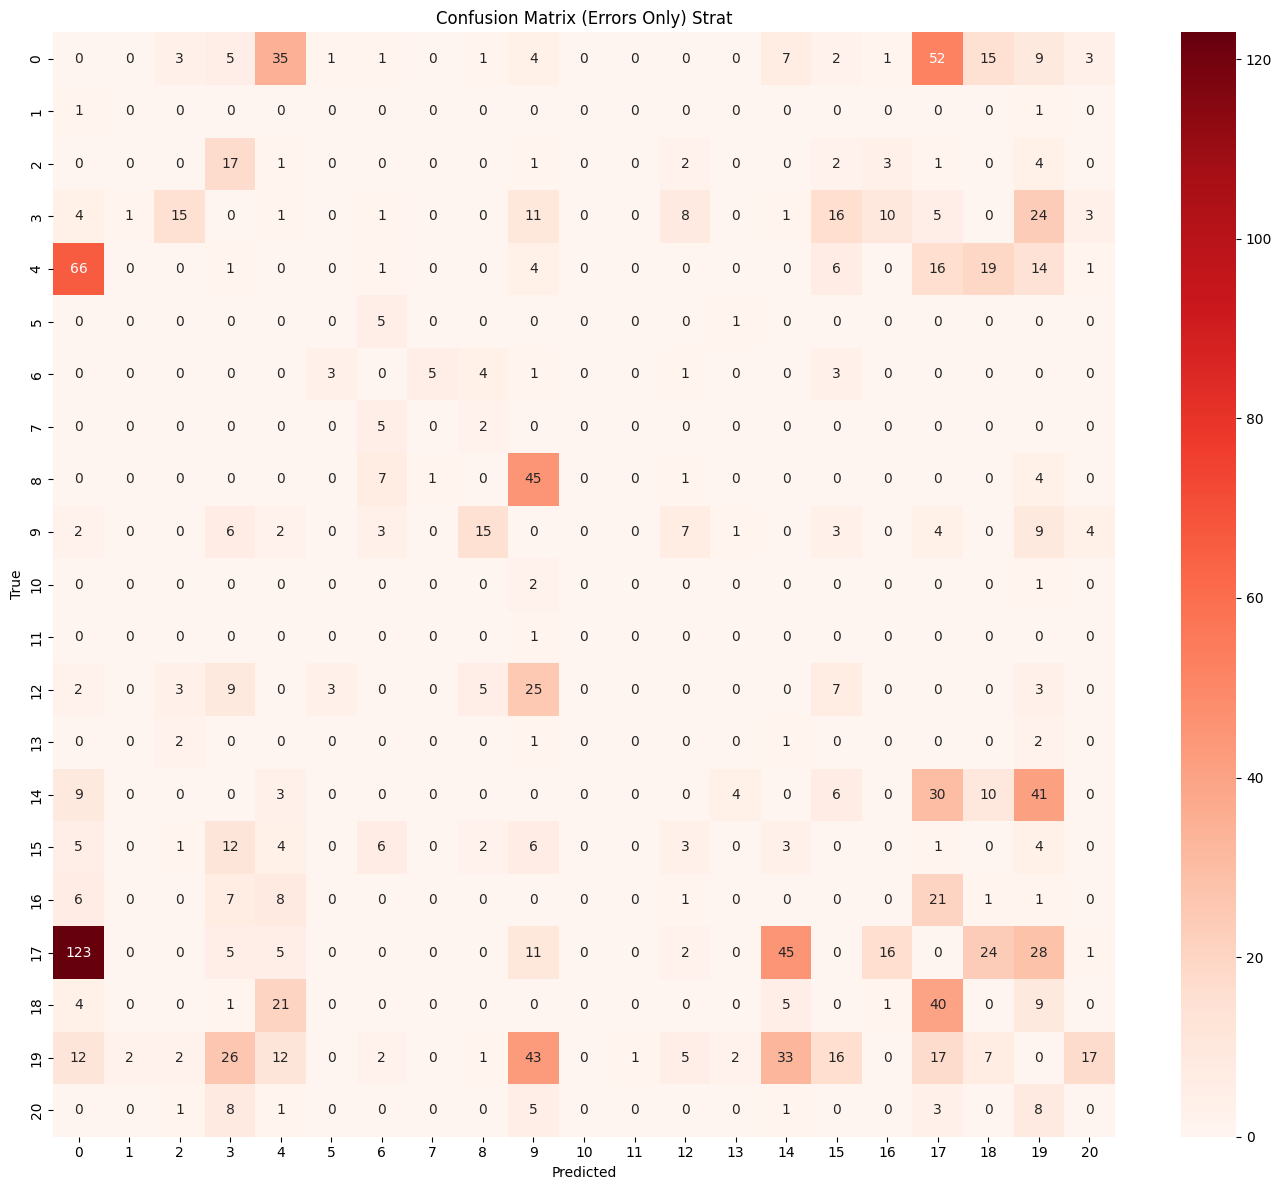

In [ ]:
# Compute raw confusion matrix.
cm_errors_strat = confusion_matrix(labels, preds)

# Set diagonal to zero to focus color scaling on the misclassifications.
cm_no_diag = cm_errors_strat.copy()
np.fill_diagonal(cm_no_diag, 0)

# Define class names for axis ticks.
class_names = [str(i) for i in range(cm_no_diag.shape[0])]

# Plot heatmap with errors emphasized.
plt.figure(figsize=(14, 12))
sns.heatmap(cm_no_diag, annot=True, fmt='d', cmap='Reds',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Errors Only) Strat')
plt.tight_layout()
plt.show()


In [ ]:
texts = {}
for cl in range(21):
    
    texts[cl] = ' '.join(df[df['class'] == cl]['clean_text'])



for cl in texts:
    plt.figure(figsize=(16, 8))
    wordcloud = WordCloud(width=800, height=600, background_color='white').generate(texts[cl])

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Class {cl}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


## 6. Temporal Split: Training on Early Years and Testing on Recent Years

Based on the distribution of samples across years, we observe that the majority of data is concentrated between 2013 and 2017, with a decreasing number of samples in later years (2018–2020). To better simulate real-world model performance and evaluate its generalization to new data, we split the dataset temporally:

- **Training set:** samples from years 2013 to 2017 (inclusive).  
- **Test set:** samples from years 2018 onwards.

This approach allows us to train the model on historical data and evaluate accuracy on more recent, potentially shifted data distributions.

In [ ]:
train_years = list(range(2013, 2018))
train_df = df[df['year'].isin(train_years)].copy()
val_df = df[~df['year'].isin(train_years)].copy()

# Rename target column to 'labels' for Trainer compatibility
train_df = train_df.rename(columns={"class": "labels"})
val_df   = val_df.rename(columns={"class": "labels"})

print("Training samples:", len(train_df))
print("Validation samples:", len(val_df))

Training samples: 149173
Validation samples: 67801


## 7. Tokenization and Preparation for Training for another step

- Select a BERT model en catalan
- Load the tokenizer using AutoTokenizer.
- Tokenize the texts and prepare PyTorch datasets for the Trainer.

In [ ]:
model_checkpoint = "PlanTL-GOB-ES/roberta-base-ca"

# Load the pretrained BERT tokenizer to convert texts into input IDs and attention masks.
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

max_length = 128  # Cover occasional longer texts and better leverage available GPU memory

def tokenize_batch(batch):
    # Tokenize texts, truncating or padding to a fixed max_length for batch processing.
    return tokenizer(
        batch["model_input"], 
        padding="max_length", 
        truncation=True, 
        max_length=max_length
    )

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

train_dataset = train_dataset.map(tokenize_batch, batched=True)
val_dataset = val_dataset.map(tokenize_batch, batched=True)


Map:   0%|          | 0/149173 [00:00<?, ? examples/s]

Map:   0%|          | 0/67801 [00:00<?, ? examples/s]

## 8. Model Building and Training

- Load the RoBERTa-base Catalan model (`PlanTL-GOB-ES/roberta-base-ca`) for sequence classification (21 output classes).
- Define training parameters with TrainingArguments.
- Train the model using Huggingface Trainer.
- Save the best model checkpoint based on validation accuracy.

In [ ]:
# Use the Catalan RoBERTa-base model for sequence classification
model_checkpoint = "PlanTL-GOB-ES/roberta-base-ca"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=21)

training_args = TrainingArguments(
    output_dir='./roberta-ca-results-years_recent',

    eval_strategy="epoch", 
    save_strategy="epoch",    

    save_total_limit=1,

    per_device_train_batch_size=128,
    per_device_eval_batch_size=256,
    num_train_epochs=3,

    learning_rate=4e-5,
    warmup_steps=500,

    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,

    logging_dir='./logs',
    logging_steps=100,
    report_to="tensorboard",

    seed=42,
    fp16=True,
    max_grad_norm=1.0
)




Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-ca and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    
    accuracy = accuracy_score(labels, preds)
    f1_macro = f1_score(labels, preds, average='macro')       # Average F1 score across classes
    precision_macro = precision_score(labels, preds, average='macro')  # Average precision across classes
    recall_macro = recall_score(labels, preds, average='macro')        # Average recall across classes
    
    return {
        "accuracy": accuracy,
        "f1_macro": f1_macro,
        "precision_macro": precision_macro,
        "recall_macro": recall_macro
    }




In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()
trainer.save_model("./best_roberta_ca_model_years")


predictions = trainer.predict(val_dataset)
preds = np.argmax(predictions.predictions, axis=-1)
labels = predictions.label_ids

print("Classification Report:")
print(classification_report(labels, preds))

print("Confusion Matrix:")
print(confusion_matrix(labels, preds))


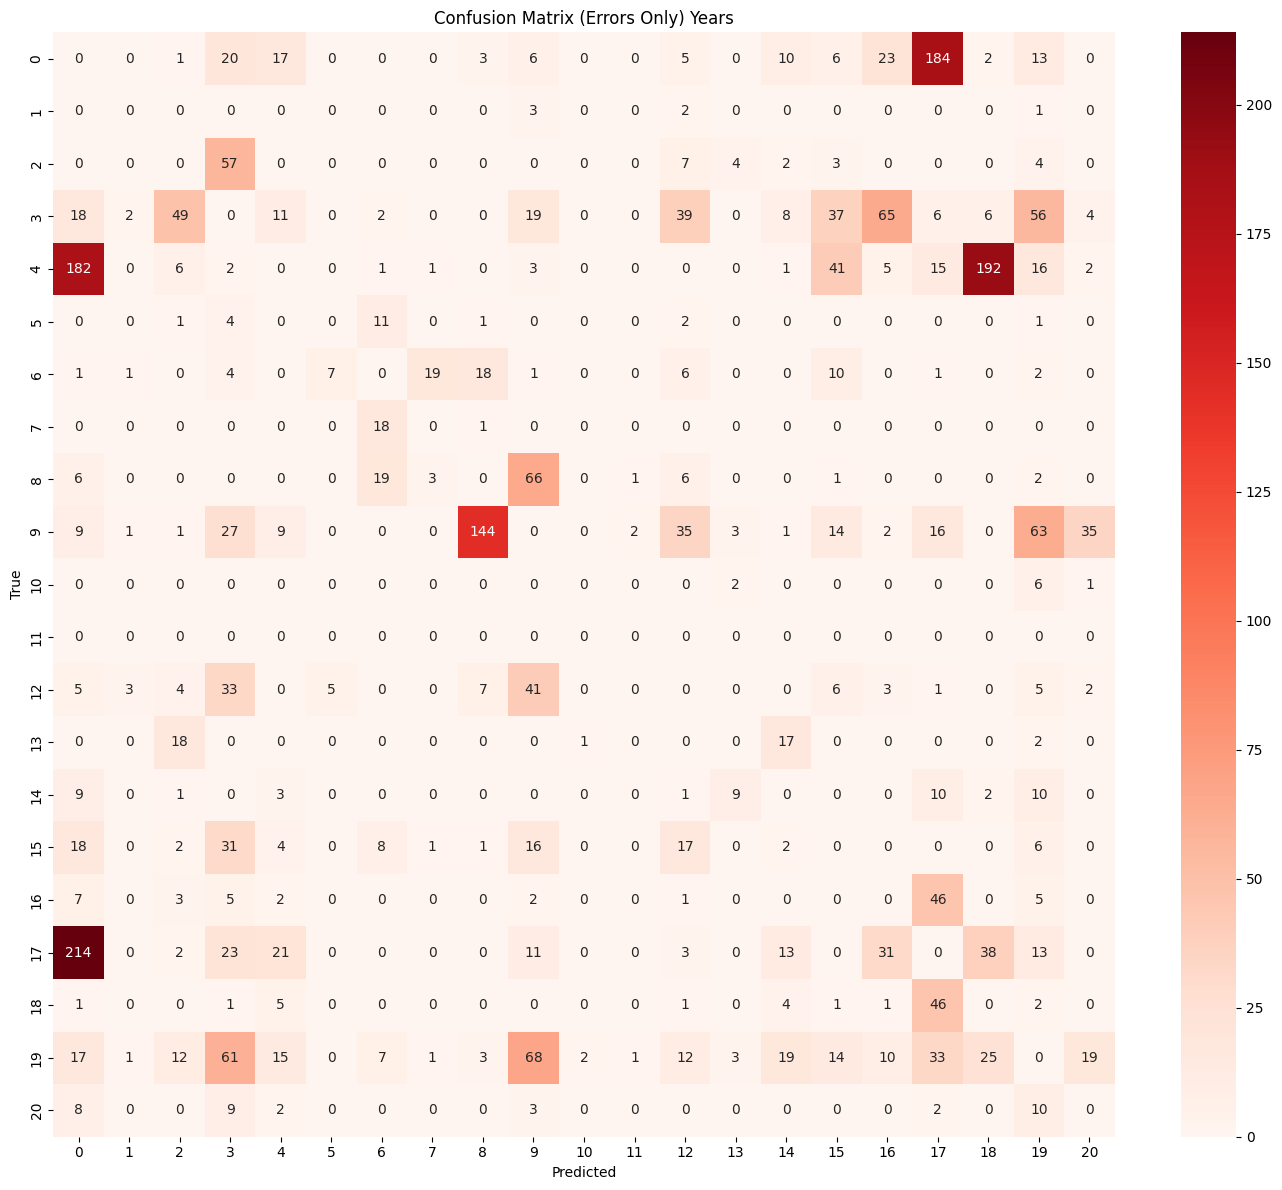

In [ ]:
cm_errors = confusion_matrix(labels, preds)

cm_no_diag = cm_errors.copy()
np.fill_diagonal(cm_no_diag, 0)

class_names = [str(i) for i in range(cm_no_diag.shape[0])]

plt.figure(figsize=(14, 12))
sns.heatmap(cm_no_diag, annot=True, fmt='d', cmap='Reds',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Errors Only) Years')
plt.tight_layout()
plt.show()


In [ ]:
train_years = [2017, 2018, 2019]
test_year   = 2020

train_df = df[df['year'].isin(train_years)].copy()
test_df  = df[df['year'] == test_year].copy()
train_df = train_df.rename(columns={'class':'labels'})
test_df  = test_df.rename(columns={'class':'labels'})

model_checkpoint = "PlanTL-GOB-ES/roberta-base-ca"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=21)

training_args = TrainingArguments(
    output_dir='./roberta-ca-results-years_recent',
    eval_strategy="epoch", 
    save_strategy="epoch",    
    save_total_limit=1,
    per_device_train_batch_size=64,    # 128 слишком много!
    per_device_eval_batch_size=128,     # 256 слишком много!
    num_train_epochs=3,
    learning_rate=4e-5,
    warmup_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,
    logging_dir='./logs',
    logging_steps=100,
    report_to="tensorboard",
    seed=42,
    fp16=True,
    max_grad_norm=1.0
)


max_length = 128
def tokenize_batch(batch):
    return tokenizer(
        batch['model_input'],
        padding='max_length',
        truncation=True,
        max_length=max_length
    )

train_ds = Dataset.from_pandas(train_df).map(tokenize_batch, batched=True)
test_ds  = Dataset.from_pandas(test_df ).map(tokenize_batch, batched=True)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics
)

trainer.train()
trainer.save_model("./best_roberta_ca_model_years_recent")

predictions = trainer.predict(test_ds)
preds = np.argmax(predictions.predictions, axis=-1)
labels = predictions.label_ids

print("Classification Report on 2020:")
print(classification_report(labels, preds))

print("Confusion Matrix on 2020:")
print(confusion_matrix(labels, preds))

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-ca and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/72912 [00:00<?, ? examples/s]

Map:   0%|          | 0/20702 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro
1,0.164600,0.224567,0.947879,0.903623,0.913356,0.897471
2,0.110100,0.219474,0.951840,0.912191,0.918600,0.908560
3,0.064100,0.219077,0.952855,0.915701,0.919876,0.914256


Classification Report on 2020:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      2115
           1       0.99      0.99      0.99       204
           2       0.97      0.97      0.97      1599
           3       0.91      0.88      0.90      1364
           4       0.86      0.87      0.86       335
           5       0.98      0.94      0.96       177
           6       0.98      0.98      0.98      1979
           7       0.92      0.99      0.95       143
           8       0.98      0.93      0.95      1124
           9       0.90      0.93      0.91      1215
          10       0.99      0.93      0.96       103
          11       1.00      1.00      1.00        18
          12       0.99      0.99      0.99      4216
          13       0.98      0.99      0.99       892
          14       0.79      0.67      0.73        55
          15       0.98      0.99      0.98      3231
          16       0.94      0.91      0.93       

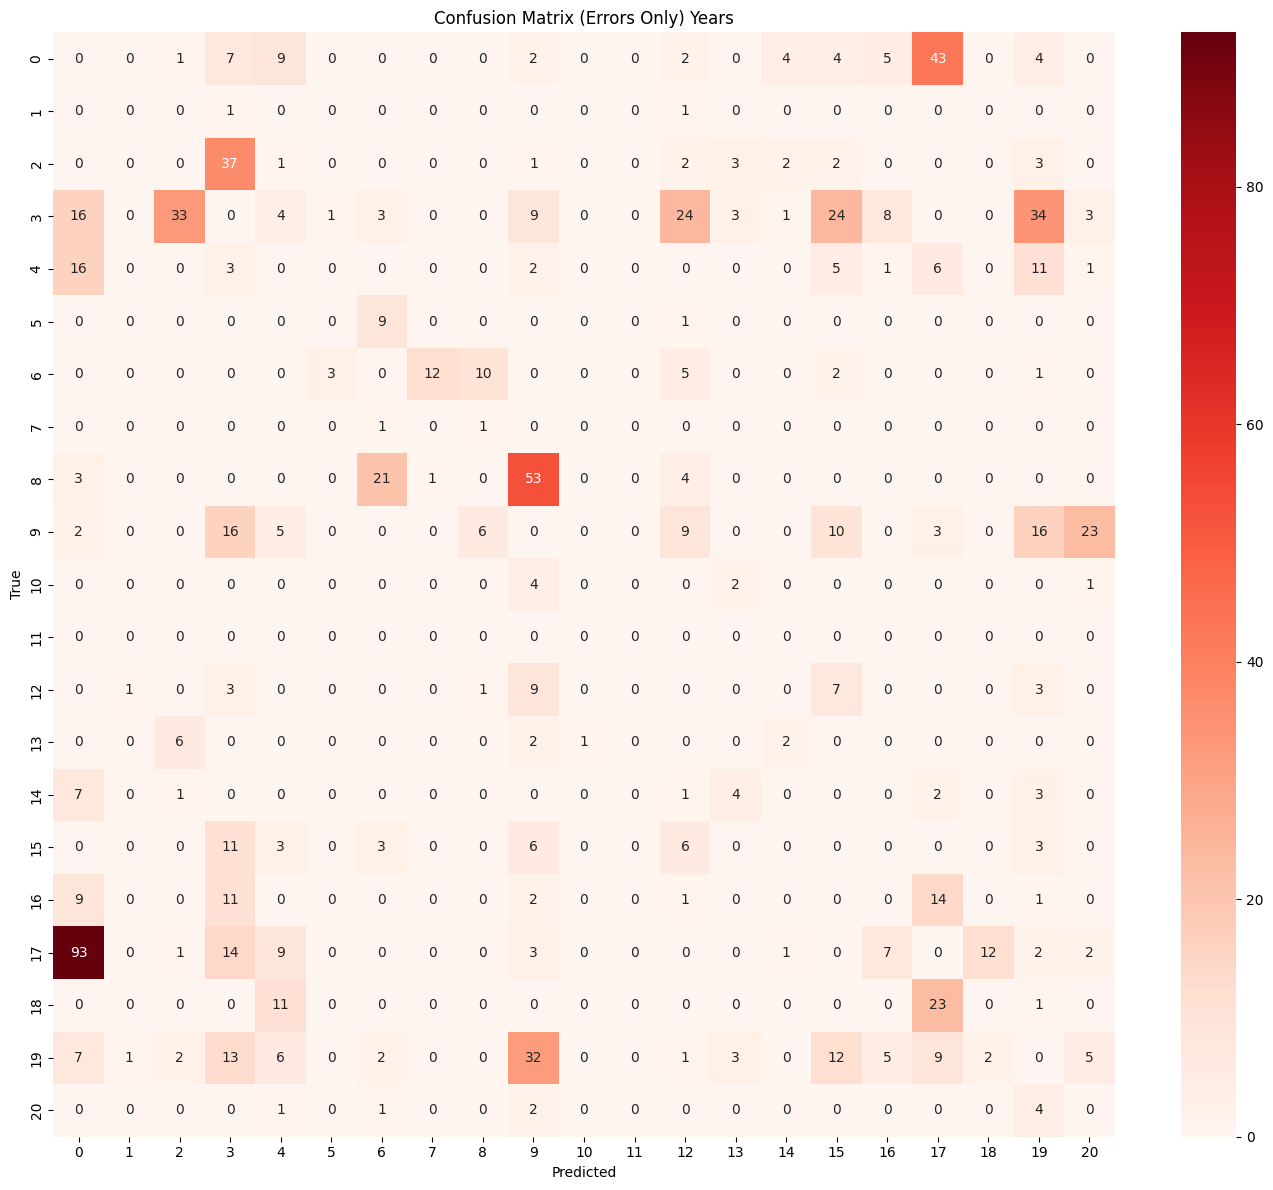

In [16]:
# Compute raw confusion matrix.
cm_rec = confusion_matrix(labels, preds)

# Set diagonal to zero to focus color scaling on the misclassifications.
cm_no_diag = cm_rec.copy()
np.fill_diagonal(cm_no_diag, 0)

# Define class names for axis ticks.
class_names = [str(i) for i in range(cm_no_diag.shape[0])]

# Plot heatmap with errors emphasized.
plt.figure(figsize=(14, 12))
sns.heatmap(cm_no_diag, annot=True, fmt='d', cmap='Reds',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Errors Only) Years')
plt.tight_layout()
plt.show()


In [ ]:
model_checkpoint = "PlanTL-GOB-ES/roberta-base-ca"
max_length = 128

def tokenize_batch(batch):
    return tokenizer(
        batch['model_input'],
        padding='max_length',
        truncation=True,
        max_length=max_length
    )

years = sorted(df['year'].unique())
accuracies_2_1 = []
accuracies_3_1 = []

# 1. 2 years train, 1 year test
for i in range(len(years)-2):
    train_years = years[i:i+2]
    test_year   = years[i+2]

    print(f"\nTrain: {train_years}  Test: {test_year}")
    train_df = df[df['year'].isin(train_years)].copy().rename(columns={'class':'labels'})
    test_df  = df[df['year'] == test_year].copy().rename(columns={'class':'labels'})

    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
    model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=21)

    training_args = TrainingArguments(
        output_dir='./roberta-ca-results',
        per_device_train_batch_size=32,
        per_device_eval_batch_size=64,
        num_train_epochs=3,
        learning_rate=4e-5,
        warmup_steps=500,
        load_best_model_at_end=True,
        metric_for_best_model='accuracy',
        eval_strategy="epoch",
        save_strategy="epoch",
        greater_is_better=True,
        logging_dir='./logs',
        logging_steps=100,
        report_to="none",
        seed=42,
        fp16=True,
        max_grad_norm=1.0
    )

    train_ds = Dataset.from_pandas(train_df).map(tokenize_batch, batched=True)
    test_ds  = Dataset.from_pandas(test_df ).map(tokenize_batch, batched=True)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=test_ds,
        compute_metrics=lambda eval_pred: {'accuracy': accuracy_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1))}
    )

    trainer.train()
    result = trainer.evaluate(test_ds)
    acc = result['eval_accuracy']
    accuracies_2_1.append(acc)
    print(f"Accuracy: {acc:.4f}")

# 2. 3 years train, 1 year test
for i in range(len(years)-3):
    train_years = years[i:i+3]
    test_year   = years[i+3]

    print(f"\nTrain: {train_years}  Test: {test_year}")
    train_df = df[df['year'].isin(train_years)].copy().rename(columns={'class':'labels'})
    test_df  = df[df['year'] == test_year].copy().rename(columns={'class':'labels'})

    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
    model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=21)

    training_args = TrainingArguments(
        output_dir='./roberta-ca-results',
        per_device_train_batch_size=32,
        per_device_eval_batch_size=64,
        num_train_epochs=3,
        learning_rate=4e-5,
        warmup_steps=500,
        load_best_model_at_end=True,
        metric_for_best_model='accuracy',
        eval_strategy="epoch",
        save_strategy="epoch",
        greater_is_better=True,
        logging_dir='./logs',
        logging_steps=100,
        report_to="none",
        seed=42,
        fp16=True,
        max_grad_norm=1.0
    )

    train_ds = Dataset.from_pandas(train_df).map(tokenize_batch, batched=True)
    test_ds  = Dataset.from_pandas(test_df ).map(tokenize_batch, batched=True)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=test_ds,
        compute_metrics=lambda eval_pred: {'accuracy': accuracy_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1))}
    )

    trainer.train()
    result = trainer.evaluate(test_ds)
    acc = result['eval_accuracy']
    accuracies_3_1.append(acc)
    print(f"Accuracy: {acc:.4f}")





Train: [2013, 2014]  Test: 2015


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-ca and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/70359 [00:00<?, ? examples/s]

Map:   0%|          | 0/29412 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy
1,0.159800,0.227156,0.946008
2,0.098700,0.200510,0.949578
3,0.067200,0.198519,0.952842


Accuracy: 0.9528

Train: [2014, 2015]  Test: 2016


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-ca and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/66001 [00:00<?, ? examples/s]

Map:   0%|          | 0/23589 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy
1,0.153100,0.189004,0.957141
2,0.112300,0.186478,0.958074
3,0.076100,0.178751,0.961762


Accuracy: 0.9618

Train: [2015, 2016]  Test: 2017


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-ca and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/53001 [00:00<?, ? examples/s]

Map:   0%|          | 0/25813 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy
1,0.154100,0.177089,0.956766
2,0.101600,0.164721,0.959207
3,0.060800,0.164379,0.962538


Accuracy: 0.9625

Train: [2016, 2017]  Test: 2018


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-ca and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/49402 [00:00<?, ? examples/s]

Map:   0%|          | 0/24734 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy
1,0.150600,0.170950,0.959853
2,0.094600,0.170417,0.961793
3,0.063400,0.169850,0.963532


Accuracy: 0.9635

Train: [2017, 2018]  Test: 2019


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-ca and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/50547 [00:00<?, ? examples/s]

Map:   0%|          | 0/22365 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy
1,0.155100,0.168388,0.961860
2,0.096100,0.144749,0.968254
3,0.065200,0.137438,0.969864


Accuracy: 0.9699

Train: [2018, 2019]  Test: 2020


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-ca and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/47099 [00:00<?, ? examples/s]

Map:   0%|          | 0/20702 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy
1,0.144300,0.249358,0.947155
2,0.123200,0.244558,0.950729
3,0.066200,0.248300,0.952034


Accuracy: 0.9520

Train: [2013, 2014, 2015]  Test: 2016


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-ca and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/99771 [00:00<?, ? examples/s]

Map:   0%|          | 0/23589 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy
1,0.143300,0.189338,0.952690
2,0.109000,0.165671,0.959854
3,0.080600,0.182245,0.959388


Accuracy: 0.9599

Train: [2014, 2015, 2016]  Test: 2017


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-ca and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/89590 [00:00<?, ? examples/s]

Map:   0%|          | 0/25813 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy
1,0.152900,0.160359,0.961337
2,0.105200,0.158265,0.960640
3,0.068100,0.157195,0.964553


Accuracy: 0.9646

Train: [2015, 2016, 2017]  Test: 2018


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-ca and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/78814 [00:00<?, ? examples/s]

Map:   0%|          | 0/24734 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy
1,0.139900,0.185398,0.955163
2,0.115300,0.146191,0.964826
3,0.068400,0.156998,0.964138


Accuracy: 0.9648

Train: [2016, 2017, 2018]  Test: 2019


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-ca and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/74136 [00:00<?, ? examples/s]

Map:   0%|          | 0/22365 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy
1,0.152500,0.147682,0.965079
2,0.104800,0.132306,0.970132
3,0.078200,0.126502,0.972144


Accuracy: 0.9721

Train: [2017, 2018, 2019]  Test: 2020


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-ca and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/72912 [00:00<?, ? examples/s]

Map:   0%|          | 0/20702 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy
1,0.163300,0.224756,0.949425
2,0.091400,0.224191,0.952806
3,0.053100,0.235773,0.954062


Accuracy: 0.9541


NameError: name 't' is not defined

In [21]:
# 3. Conf int
def print_ci(accuracies, label):
    acc = np.array(accuracies)
    mean = acc.mean()
    std = acc.std(ddof=1)
    n = len(acc)
    alpha = 0.05
    t_score = t.ppf(1 - alpha/2, n - 1)
    ci_halfwidth = t_score * std / np.sqrt(n)
    print(f"\n{label}:")
    print(f"Mean accuracy: {mean:.3f}")
    print(f"95% CI: [{mean - ci_halfwidth:.3f}, {mean + ci_halfwidth:.3f}]")

print_ci(accuracies_2_1, "2 train + 1 test")
print_ci(accuracies_3_1, "3 train + 1 test")


2 train + 1 test:
Mean accuracy: 0.960
95% CI: [0.953, 0.968]

3 train + 1 test:
Mean accuracy: 0.963
95% CI: [0.955, 0.971]
